In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
import scipy.stats as stats
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score

In [2]:
def gridSearch(X, Y, repeat, n_splits, scorer, mod, hyperparameters,  n_jobs=None, stratify=True):
    # GridSearch Wrapper Fucntion
    print("Number of repeats run is: " + str(repeat))
    dfL = []
    for i in range(0,repeat):
        if stratify==True:
            cv = StratifiedKFold(n_splits=n_splits, random_state=i, shuffle=True)
        else:
            cv = KFold(n_splits=n_splits, random_state=i, shuffle=True)
        boosted_grid = GridSearchCV(mod, hyperparameters, scoring=scorer, cv=cv, verbose=0, refit=True, error_score=np.nan, return_train_score=True, n_jobs=n_jobs) #n_jobs=n_jobs,
        grid_fit = boosted_grid.fit(X, Y)
        DF = pd.DataFrame(grid_fit.cv_results_)
        DF['Iteration'] = i
        dfL.append(DF)
    DFall = pd.concat(dfL)
    return DFall


def OverSampler(parentDIR,df, xfilename, yfilename):
    # Oversample small class to balanced data
    os.chdir(parentDIR)
    df = df.dropna()
    X = df.iloc[:,4:].copy()
    X['TimeGroup'] = df.TimeGroup.copy()
    X = pd.get_dummies(X)
    Y = df.Status.copy()

    ros = RandomOverSampler(random_state=0)
    Xoversampled, Yoversampled = ros.fit_resample(X, Y)

    if not os.path.isdir('OverSampled'):
        os.makedirs('OverSampled')
    os.chdir('OverSampled')

    Xoversampled.to_csv(xfilename, sep='\t')
    Yoversampled.to_csv(yfilename, sep='\t')
    return Xoversampled, Yoversampled

In [3]:
parentdir = os.getcwd()
Clean = pd.read_csv('CleanedData.txt', sep='\t', index_col=0)
Clean.Status.replace('Melioid', 1, inplace=True)
Clean.Status.replace('Negative', 0, inplace=True)

os.chdir(parentdir)
Clean.dropna(inplace=True)
X = Clean.iloc[:,4:].copy()
X['TimeGroup'] = Clean.TimeGroup.copy()
X = pd.get_dummies(X)
Y = Clean.Status.copy()

In [4]:
os.chdir(parentdir)
if not os.path.isdir('NonResampled/Results'):
    os.makedirs('NonResampled/Results')
os.chdir('NonResampled/Results')
RAND=np.random.RandomState(4)

# param_space = {'C':np.logspace(-5,2,4),
#                 'l1_ratio':[float(x) for x in np.linspace(0.1,0.9,4)]}
# enet = LogisticRegression(penalty = 'elasticnet', solver = 'saga', max_iter=int(1e6))

# Enet = gridSearch(X=X, Y=Y, repeat=100, n_splits=10, scorer='balanced_accuracy', mod=enet, hyperparameters=param_space, n_jobs=6, stratify=True) #, n_jobs=numCores
# Enet.to_csv('W1_EnetBurkPx_GridSearch.txt', sep='\t')
# Enet['params2'] = Enet['params'].astype(str)
# print('Finished Enet')


# param_space = {'C':np.logspace(-5,3,10),
#                 'penalty':['l1', 'l2']}
# lr = LogisticRegression( solver = 'saga', max_iter=int(1e6))

# LR = gridSearch(X=X, Y=Y, repeat=100, n_splits=10, scorer='balanced_accuracy', mod=lr, hyperparameters=param_space, n_jobs=6, stratify=True) #, n_jobs=numCores
# LR.to_csv('W1_LRBurkPx_GridSearch.txt', sep='\t')
# LR['params2'] = LR['params'].astype(str)
# print('Finished LR')


param_space = {'learning_rate': np.logspace(-3, -1,4),
                'n_estimators': [25, 50],
                'subsample': np.linspace(0.2,0.9,3),
                'colsample_bytree':np.linspace(0.05, 0.5, 3),
                'max_depth':[int(x) for x in np.linspace(3,20,3)]}

xgb =  XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=RAND) #, scale_pos_weight=len(Y1==0)/len(Y1==1) BinaryFocalLoss

LR = gridSearch(X=X, Y=Y, repeat=100, n_splits=10, scorer='balanced_accuracy', mod=xgb, hyperparameters=param_space, n_jobs=6, stratify=True) #, n_jobs=numCores
LR.to_csv('W1_XGBBurkPx_GridSearch.txt', sep='\t')
LR['params2'] = LR['params'].astype(str)

Number of repeats run is: 100


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 [Text(0, 0, "{'C': 1e-05, 'l1_ratio': 0.1}"),
  Text(1, 0, "{'C': 1e-05, 'l1_ratio': 0.3666666666666667}"),
  Text(2, 0, "{'C': 1e-05, 'l1_ratio': 0.6333333333333333}"),
  Text(3, 0, "{'C': 1e-05, 'l1_ratio': 0.9}"),
  Text(4, 0, "{'C': 0.0021544346900318843, 'l1_ratio': 0.1}"),
  Text(5, 0, "{'C': 0.0021544346900318843, 'l1_ratio': 0.3666666666666667}"),
  Text(6, 0, "{'C': 0.0021544346900318843, 'l1_ratio': 0.6333333333333333}"),
  Text(7, 0, "{'C': 0.0021544346900318843, 'l1_ratio': 0.9}"),
  Text(8, 0, "{'C': 0.4641588833612782, 'l1_ratio': 0.1}"),
  Text(9, 0, "{'C': 0.4641588833612782, 'l1_ratio': 0.3666666666666667}"),
  Text(10, 0, "{'C': 0.4641588833612782, 'l1_ratio': 0.6333333333333333}"),
  Text(11, 0, "{'C': 0.4641588833612782, 'l1_ratio': 0.9}"),
  Text(12, 0, "{'C': 100.0, 'l1_ratio': 0.1}"),
  Text(13, 0, "{'C': 100.0, 'l1_ratio': 0.3666666666666667}"),
  Text(14, 0, "{'C': 100.0, 'l1_ratio': 0.6

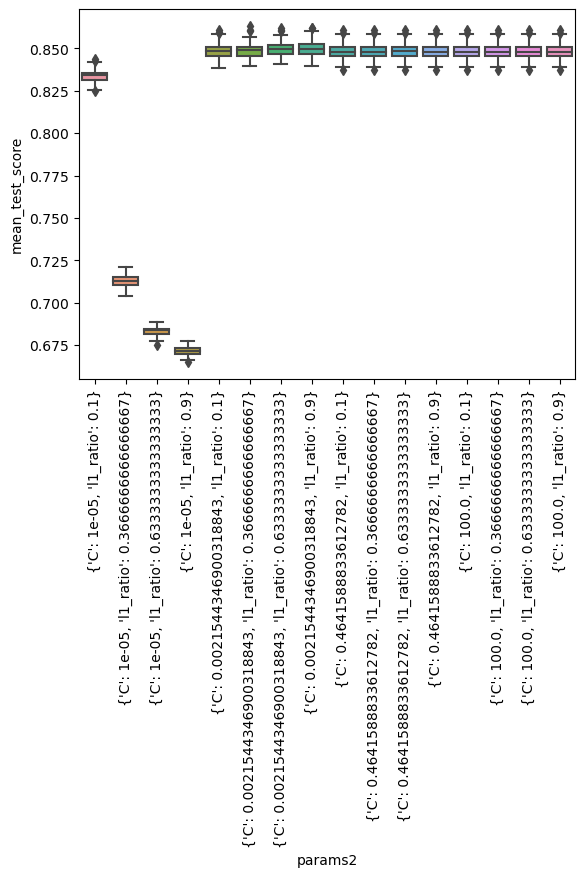

In [4]:
os.chdir('/Users/paulmacos/githubrepos/public/BurkPx_BuscagliaPhillips/data/RAW/NonResampled/Results')
LR = pd.read_csv('W1_EnetBurkPx_GridSearch.txt', sep='\t', index_col=0)
LR['params2'] = LR['params'].astype(str)
fig, ax = plt.subplots()
sns.boxplot(data=LR, y= 'mean_test_score', x='params2', ax=ax)
plt.xticks(rotation=90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, "{'C': 1e-05, 'penalty': 'l1'}"),
  Text(1, 0, "{'C': 1e-05, 'penalty': 'l2'}"),
  Text(2, 0, "{'C': 7.742636826811278e-05, 'penalty': 'l1'}"),
  Text(3, 0, "{'C': 7.742636826811278e-05, 'penalty': 'l2'}"),
  Text(4, 0, "{'C': 0.0005994842503189409, 'penalty': 'l1'}"),
  Text(5, 0, "{'C': 0.0005994842503189409, 'penalty': 'l2'}"),
  Text(6, 0, "{'C': 0.004641588833612777, 'penalty': 'l1'}"),
  Text(7, 0, "{'C': 0.004641588833612777, 'penalty': 'l2'}"),
  Text(8, 0, "{'C': 0.03593813663804626, 'penalty': 'l1'}"),
  Text(9, 0, "{'C': 0.03593813663804626, 'penalty': 'l2'}"),
  Text(10, 0, "{'C': 0.2782559402207126, 'penalty': 'l1'}"),
  Text(11, 0, "{'C': 0.2782559402207126, 'penalty': 'l2'}"),
  Text(12, 0, "{'C': 2.154434690031882, 'penalty': 'l1'}"),
  Text(13, 0, "{'C': 2.154434690031882, 'penalty': 'l2'}"),
  Text(14, 0, "{'C': 16.681005372000556, 'penalty': 'l1'}"),
  Text(

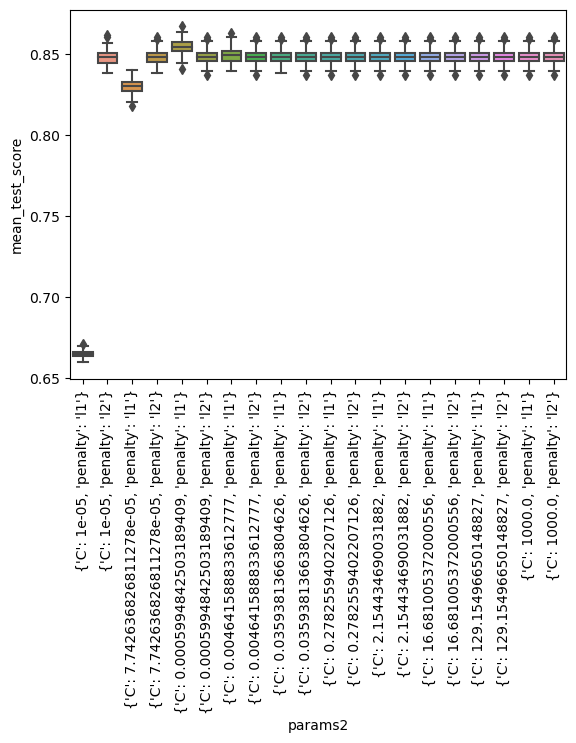

In [5]:
LR = pd.read_csv('W1_LRBurkPx_GridSearch.txt', sep='\t', index_col=0)
LR['params2'] = LR['params'].astype(str)
fig, ax = plt.subplots()
sns.boxplot(data=LR, y= 'mean_test_score', x='params2', ax=ax)
plt.xticks(rotation=90)

In [ ]:
LR = pd.read_csv('W1_XGBBurkPx_GridSearch.txt', sep='\t', index_col=0)
LR['params2'] = LR['params'].astype(str)
fig, ax = plt.subplots()
sns.boxplot(data=LR, y= 'mean_test_score', x='params2', ax=ax)
plt.xticks(rotation=90)

## Validation Set
### Enet

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
os.chdir('/Users/paulmacos/githubrepos/public/BurkPx_BuscagliaPhillips/data/RAW/ValidationSet')

df = pd.read_csv('ValidationSet.txt', sep='\t', index_col=0)
Week2 = df.loc[(df['TimeGroup']=='Week2')|(df['TimeGroup']=='Healthy')]

yVAL = Week2.Status.copy()
yVAL.replace('Melioid', 1, inplace=True)
yVAL.replace('Negative', 0, inplace=True)

XVAL = Week2.iloc[:,4:].copy()
XVAL = pd.get_dummies(XVAL)

ros = RandomUnderSampler(random_state=0)
Xunder, Yunder = ros.fit_resample(XVAL, yVAL)


enet = LogisticRegression(penalty = 'elasticnet', C=0.0021544346900318843, l1_ratio=0.6333333333333333, solver = 'saga', max_iter=int(1e6)).fit(Xunder, Yunder)
# roc_auc_score(y, clf.predict_proba(X)[:, 1])
roc_auc_score(Yunder, enet.predict_proba(Xunder)[:, 1])
# roc_auc_score(yVAL, enet.decision_function(XVAL))

# BestLR = {'C': 0.0005994842503189409, 'penalty': 'l1'}

## Coefficients
### Enet

In [ ]:
parentdir = os.getcwd()
Clean = pd.read_csv('CleanedData.txt', sep='\t', index_col=0)
Clean.Status.replace('Melioid', 1, inplace=True)
Clean.Status.replace('Negative', 0, inplace=True)

os.chdir(parentdir)
Clean.dropna(inplace=True)
X = Clean.iloc[:,4:].copy()
X['TimeGroup'] = Clean.TimeGroup.copy()
X = pd.get_dummies(X)
Y = Clean.Status.copy()

enet = LogisticRegression(penalty = 'elasticnet', C=0.0005994842503189409, l1_ratio=0.6333333333333333, solver = 'saga', max_iter=int(1e6)).fit(X, Y)
CoefDF = pd.DataFrame({'Coefs':enet.coef_, 'Feauture':enet.feautrenames_in_})

### LR

In [23]:
parentdir = os.getcwd()
Clean = pd.read_csv('../../CleanedData.txt', sep='\t', index_col=0)
Clean.Status.replace('Melioid', 1, inplace=True)
Clean.Status.replace('Negative', 0, inplace=True)

os.chdir(parentdir)
Clean.dropna(inplace=True)
X = Clean.iloc[:,4:].copy()
X['TimeGroup'] = Clean.TimeGroup.copy()
X = pd.get_dummies(X)
Y = Clean.Status.copy()

LRstrong = LogisticRegression(penalty = 'l1', C=0.0021544346900318843, solver = 'saga', max_iter=int(1e6)).fit(X, Y)
coefsDFSTRONG = pd.DataFrame(np.transpose(LRstrong.coef_), X.columns, columns=['Coefficients'])

LRweak = LogisticRegression(penalty = 'l1', C=1000, solver = 'saga', max_iter=int(1e6)).fit(X, Y)
CoefDFWEAK = pd.DataFrame(np.transpose(LRweak.coef_), X.columns, columns=['Coefficients'])

ValueError: Per-column arrays must each be 1-dimensional